In [1]:
import re
import joblib
from joblib import dump, load

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sklearn
from sklearn.base import (
    BaseEstimator, 
    TransformerMixin
)

from imblearn.under_sampling import RandomUnderSampler

from sklearn.preprocessing import (
    LabelEncoder, 
)

from sklearn.model_selection import (
    train_test_split,
)

from sklearn.ensemble import VotingClassifier


from sklearn.metrics import (
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score,
    fbeta_score,
    roc_auc_score, 
    average_precision_score,
    confusion_matrix, 
    classification_report, 
    ConfusionMatrixDisplay, 
    RocCurveDisplay, 
    precision_recall_curve,
)

from sklearn import set_config

pd.set_option('display.max_columns', None)
pd.options.plotting.backend = 'matplotlib'
set_config(transform_output='pandas')

In [2]:
print(sklearn.__version__)
print(joblib.__version__)

1.4.2
1.4.0


In [3]:
class TweakCustomerChurn(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):

        digital_product_cols = ['games_product', 'music_product', 'education_product', 'video_product']
        all_product_cols = ['games_product', 'music_product', 'education_product', 'video_product', 'call_center', 'use_myapp']
        
        return (X
                .rename(columns=lambda col: re.compile(r'[^a-zA-Z0-9_]+').sub('_', col.lower()))
                .assign(tenure_segmentation=lambda df_: np.where(df_.tenure_months < 4, "low", np.where(df_.tenure_months < 12, "medium", "high")),
                        any_digital_product=lambda df_: np.where((df_.games_product == "Yes") | (df_.music_product == "Yes") | (df_.education_product == "Yes") | (df_.video_product == "Yes"), 1, 0),
                        all_digital_product=lambda df_: np.where((df_.games_product == "Yes") & (df_.music_product == "Yes") & (df_.education_product == "Yes") & (df_.video_product == "Yes"), 1, 0),
                        total_digital_product_used=lambda df_: df_[digital_product_cols].apply(lambda row: sum(row == 'Yes'), axis=1),
                        total_product_utilisation=lambda df_: df_[all_product_cols].apply(lambda row: sum(row == 'Yes'), axis=1),
                        total_spending=lambda df_: df_.tenure_months.mul(df_.monthly_purchase_thou_idr_),
                        net_cltv_total_spending=lambda df_: df_.cltv_predicted_thou_idr_.sub(df_.total_spending)
                        )
                .astype({**{k: "int8"
                            for k in ["tenure_months", "any_digital_product", "all_digital_product", "total_digital_product_used", "total_product_utilisation"]},
                         **{k: "float16"
                            for k in ["monthly_purchase_thou_idr_", "cltv_predicted_thou_idr_", "total_spending", "net_cltv_total_spending"]},
                         **{k: "category"
                            for k in ["tenure_segmentation", "location", "device_class", "games_product", "music_product", "education_product", "call_center", "video_product", "use_myapp", "payment_method"]}})
                .reindex(columns=["tenure_months", "tenure_segmentation", "location", "device_class", "games_product", "music_product", "education_product", "video_product", "any_digital_product", "all_digital_product", "total_digital_product_used", "call_center", "use_myapp", "total_product_utilisation", "payment_method", "monthly_purchase_thou_idr_", "cltv_predicted_thou_idr_", "total_spending", "net_cltv_total_spending"])
               )

In [4]:
# Load the model from the file
loaded_model_xgb = load('../../models/best_model_telco_churn.joblib')

In [5]:
# Load the pipeline from the file
loaded_pipeline_xgb = load('../../models/best_pipeline_telco_churn.joblib')

In [6]:
# Load the model from the file
loaded_model_logreg = load('../../models/best_model_telco_churn_logreg.joblib')

In [7]:
# Load the pipeline from the file
loaded_pipeline_logreg = load('../../models/best_pipeline_telco_churn_logreg.joblib')

In [8]:
# Load the model from the file
loaded_model_svc = load('../../models/best_model_telco_churn_svc.joblib')

In [9]:
# Load the pipeline from the file
loaded_pipeline_svc = load('../../models/best_pipeline_telco_churn_svc.joblib')

In [10]:
df = (pd
      .read_excel('../../data/raw/Telco_customer_churn_adapted_v2.xlsx')
     )

In [11]:
label_encoder = LabelEncoder()
df = (df
      .rename(columns={'Churn Label': 'churn_label'})
      .assign(churn_label=lambda df_: label_encoder.fit_transform(df_.churn_label))
      .astype({'churn_label': 'int8'})
     )
df

,Customer ID,Tenure Months,Location,Device Class,Games Product,Music Product,Education Product,Call Center,Video Product,Use MyApp,Payment Method,Monthly Purchase (Thou. IDR),churn_label,Longitude,Latitude,CLTV (Predicted Thou. IDR)
0,0,2,Jakarta,Mid End,Yes,Yes,No,No,No,No,Digital Wallet,70.005,1,106.816666,-6.2,4210.7
1,1,2,Jakarta,High End,No,No,No,No,No,No,Pulsa,91.910,1,106.816666,-6.2,3511.3
2,2,8,Jakarta,High End,No,No,Yes,No,Yes,Yes,Pulsa,129.545,1,106.816666,-6.2,6983.6
3,3,28,Jakarta,High End,No,No,Yes,Yes,Yes,Yes,Pulsa,136.240,1,106.816666,-6.2,6503.9
4,4,49,Jakarta,High End,No,Yes,Yes,No,Yes,Yes,Debit,134.810,1,106.816666,-6.2,6942.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,7038,72,Jakarta,Low End,No internet service,No internet service,No internet service,No,No internet service,No internet service,Debit,27.495,0,106.816666,-6.2,6897.8
7039,7039,24,Jakarta,Mid End,Yes,No,Yes,Yes,Yes,Yes,Digital Wallet,110.240,0,106.816666,-6.2,2782.0
7040,7040,72,Jakarta,High End,No,Yes,Yes,No,Yes,Yes,Credit,134.160,0,106.816666,-6.2,7228.0
7041,7041,11,Jakarta,Mid End,Yes,No,No,No,No,No,Pulsa,38.480,0,106.816666,-6.2,3630.9


In [12]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['Customer ID', 'Latitude', 'Longitude', 'churn_label']),
                                                    df[['churn_label']].values.ravel(),
                                                    test_size=0.2,
                                                    stratify=df[['churn_label']].values.ravel(),
                                                    random_state=42)

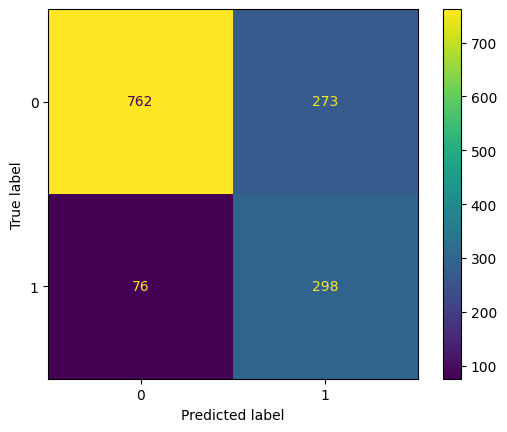

In [13]:
ConfusionMatrixDisplay(confusion_matrix(y_test, loaded_model_xgb.predict(loaded_pipeline_xgb.transform(X_test)))).plot();

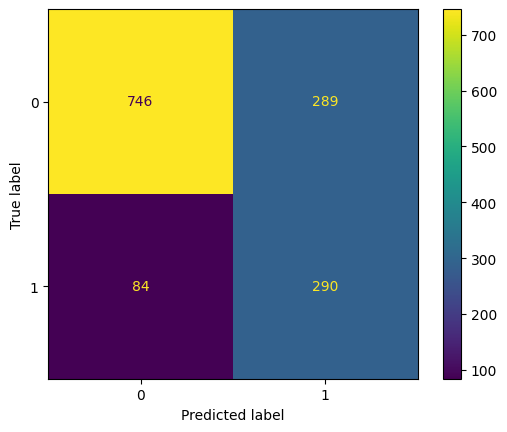

In [14]:
ConfusionMatrixDisplay(confusion_matrix(y_test, loaded_model_logreg.predict(loaded_pipeline_logreg.transform(X_test)))).plot();

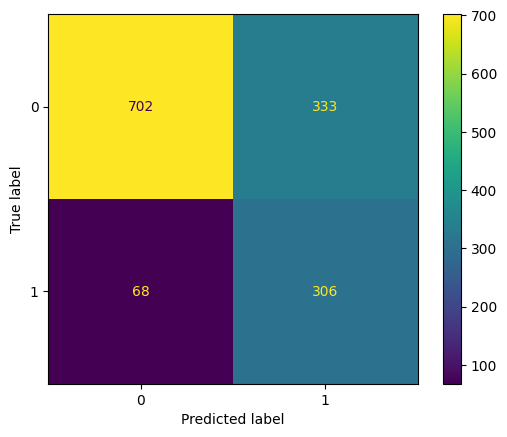

In [15]:
ConfusionMatrixDisplay(confusion_matrix(y_test, loaded_model_svc.predict(loaded_pipeline_svc.transform(X_test)))).plot();

In [16]:
print(f'Accuracy score: {accuracy_score(y_test, loaded_model_xgb.predict(loaded_pipeline_xgb.transform(X_test)))}')
print(f'Precision score: {precision_score(y_test, loaded_model_xgb.predict(loaded_pipeline_xgb.transform(X_test)))}')
print(f'Recall score: {recall_score(y_test, loaded_model_xgb.predict(loaded_pipeline_xgb.transform(X_test)))}')
print(f'F1 score: {f1_score(y_test, loaded_model_xgb.predict(loaded_pipeline_xgb.transform(X_test)))}')
print(f'ROC-AUC score: {roc_auc_score(y_test, loaded_model_xgb.predict_proba(loaded_pipeline_xgb.transform(X_test))[:, 1])}')
print(f'Average Precision Score: {average_precision_score(y_test, loaded_model_xgb.predict_proba(loaded_pipeline_xgb.transform(X_test))[:, 1])}')

Accuracy score: 0.752306600425834
Precision score: 0.521891418563923
Recall score: 0.7967914438502673
F1 score: 0.6306878306878307
ROC-AUC score: 0.8386512180629827
Average Precision Score: 0.6527931913504662


In [17]:
print(f'Accuracy score: {accuracy_score(y_test, loaded_model_logreg.predict(loaded_pipeline_logreg.transform(X_test)))}')
print(f'Precision score: {precision_score(y_test, loaded_model_logreg.predict(loaded_pipeline_logreg.transform(X_test)))}')
print(f'Recall score: {recall_score(y_test, loaded_model_logreg.predict(loaded_pipeline_logreg.transform(X_test)))}')
print(f'F1 score: {f1_score(y_test, loaded_model_logreg.predict(loaded_pipeline_logreg.transform(X_test)))}')
print(f'ROC-AUC score: {roc_auc_score(y_test, loaded_model_logreg.predict_proba(loaded_pipeline_logreg.transform(X_test))[:, 1])}')
print(f'Average Precision Score: {average_precision_score(y_test, loaded_model_logreg.predict_proba(loaded_pipeline_logreg.transform(X_test))[:, 1])}')

Accuracy score: 0.7352732434350603
Precision score: 0.5008635578583766
Recall score: 0.7754010695187166
F1 score: 0.608604407135362
ROC-AUC score: 0.8327753235681623
Average Precision Score: 0.6424060672444474


In [18]:
print(f'Accuracy score: {accuracy_score(y_test, loaded_model_svc.predict(loaded_pipeline_svc.transform(X_test)))}')
print(f'Precision score: {precision_score(y_test, loaded_model_svc.predict(loaded_pipeline_svc.transform(X_test)))}')
print(f'Recall score: {recall_score(y_test, loaded_model_svc.predict(loaded_pipeline_svc.transform(X_test)))}')
print(f'F1 score: {f1_score(y_test, loaded_model_svc.predict(loaded_pipeline_svc.transform(X_test)))}')
print(f'ROC-AUC score: {roc_auc_score(y_test, loaded_model_svc.predict_proba(loaded_pipeline_svc.transform(X_test))[:, 1])}')
print(f'Average Precision Score: {average_precision_score(y_test, loaded_model_svc.predict_proba(loaded_pipeline_svc.transform(X_test))[:, 1])}')

Accuracy score: 0.7154009936124911
Precision score: 0.4788732394366197
Recall score: 0.8181818181818182
F1 score: 0.6041461006910168
ROC-AUC score: 0.8303275723991836
Average Precision Score: 0.6172532234170823


In [19]:
X_train = loaded_pipeline_logreg.transform(X_train)
X_test = loaded_pipeline_logreg.transform(X_test)

In [20]:
rus = RandomUnderSampler(random_state=42)
X_train, y_train = rus.fit_resample(X_train, y_train)

In [21]:
clf1 = loaded_model_xgb
clf2 = loaded_model_logreg
clf3 = loaded_model_svc

eclf1 = VotingClassifier(estimators=[('xgb', clf1), 
                                     ('logreg', clf2), 
                                     ('svc', clf3)], 
                         voting='hard')

eclf2 = VotingClassifier(estimators=[('lr', clf1), 
                                     ('rf', clf2), 
                                     ('gnb', clf3)],
                         voting='soft')

In [22]:
eclf1 = eclf1.fit(X_train, y_train)
print(eclf1.predict(X_test))

[0 1 0 ... 0 0 0]


In [23]:
eclf2 = eclf2.fit(X_train, y_train)
print(eclf2.predict(X_test))

[0 1 0 ... 0 0 0]


In [24]:
print(classification_report(y_test, eclf1.predict(X_test)))

              precision    recall  f1-score   support

           0       0.90      0.72      0.80      1035
           1       0.50      0.79      0.61       374

    accuracy                           0.74      1409
   macro avg       0.70      0.75      0.71      1409
weighted avg       0.80      0.74      0.75      1409



In [25]:
print(f'Accuracy score: {accuracy_score(y_test, eclf1.predict(X_test))}')
print(f'Precision score: {precision_score(y_test, eclf1.predict(X_test))}')
print(f'Recall score: {recall_score(y_test, eclf1.predict(X_test))}')
print(f'F1 score: {f1_score(y_test, eclf1.predict(X_test))}')

Accuracy score: 0.7352732434350603
Precision score: 0.5008488964346349
Recall score: 0.7887700534759359
F1 score: 0.612668743509865


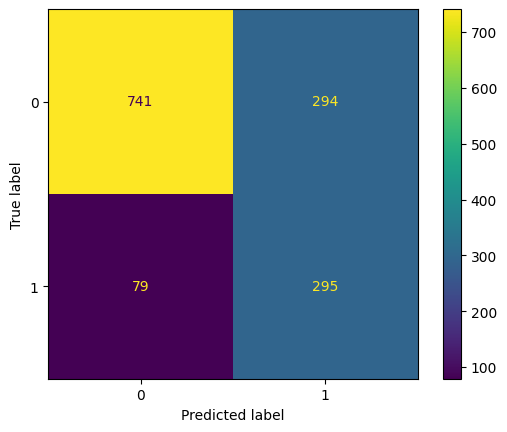

In [26]:
ConfusionMatrixDisplay(confusion_matrix(y_test, eclf1.predict(X_test))).plot();

In [27]:
print(classification_report(y_test, eclf2.predict(X_test)))

              precision    recall  f1-score   support

           0       0.90      0.71      0.80      1035
           1       0.50      0.79      0.61       374

    accuracy                           0.73      1409
   macro avg       0.70      0.75      0.70      1409
weighted avg       0.80      0.73      0.75      1409



In [28]:
print(f'Accuracy score: {accuracy_score(y_test, eclf2.predict(X_test))}')
print(f'Precision score: {precision_score(y_test, eclf2.predict(X_test))}')
print(f'Recall score: {recall_score(y_test, eclf2.predict(X_test))}')
print(f'F1 score: {f1_score(y_test, eclf2.predict(X_test))}')
print(f'ROC-AUC score: {roc_auc_score(y_test, eclf2.predict_proba(X_test)[:, 1])}')
print(f'Average Precision Score: {average_precision_score(y_test, eclf2.predict_proba(X_test)[:, 1])}')

Accuracy score: 0.7331440738112136
Precision score: 0.49830508474576274
Recall score: 0.786096256684492
F1 score: 0.6099585062240664
ROC-AUC score: 0.8372678188534967
Average Precision Score: 0.6492189378250763


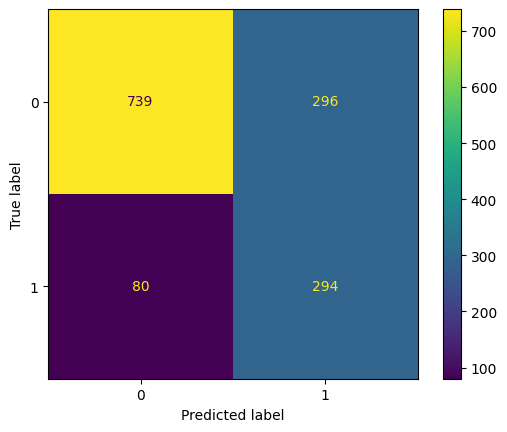

In [29]:
ConfusionMatrixDisplay(confusion_matrix(y_test, eclf2.predict(X_test))).plot();

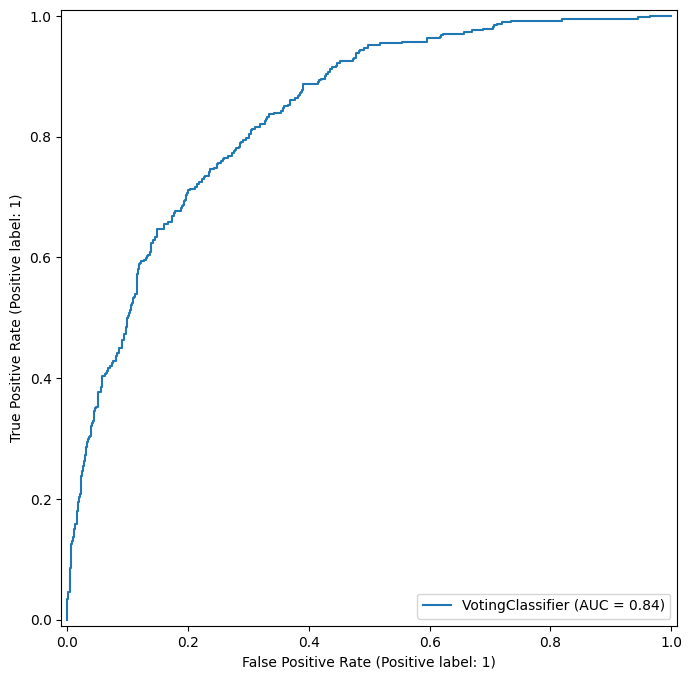

In [30]:
fig, ax = plt.subplots(figsize=(8,8))
RocCurveDisplay.from_estimator(eclf2,
                               X_test,
                               y_test,
                               ax=ax,);

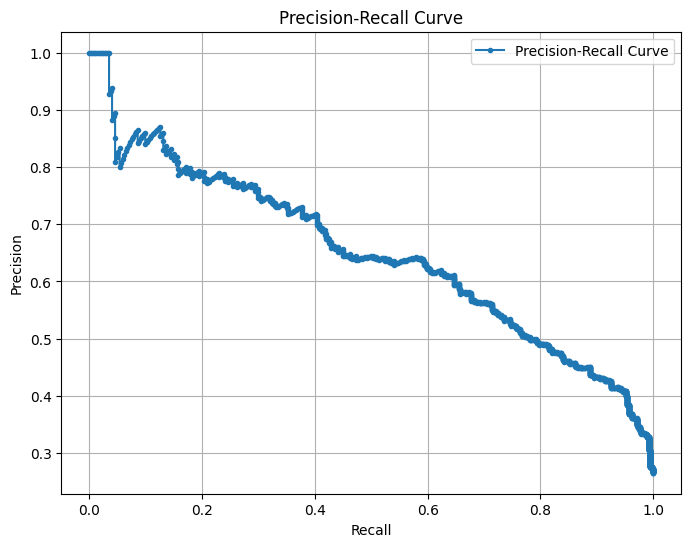

In [31]:
precision, recall, thresholds = precision_recall_curve(y_test, eclf2.predict_proba(X_test)[:,1])
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.legend()
plt.show()

In [32]:
thresholds = np.linspace(0, 1, 100)
f1_scores = [f1_score(y_test, eclf2.predict_proba(X_test)[:,1] > thr) for thr in thresholds]
fbeta_scores = [fbeta_score(y_test, eclf2.predict_proba(X_test)[:,1] > thr, beta=1.5) for thr in thresholds]
fbeta_scores1_8 = [fbeta_score(y_test, eclf2.predict_proba(X_test)[:,1] > thr, beta=1.8) for thr in thresholds]

# Get threshold with highest F1 score
optimal_threshold_f1 = thresholds[np.argmax(f1_scores)]
optimal_threshold_fbeta = thresholds[np.argmax(fbeta_scores)]
optimal_threshold_fbeta1_8 = thresholds[np.argmax(fbeta_scores1_8)]

print(f'Optimal threshold based on f1: {optimal_threshold_f1}')
print(f'Optimal threshold based on fbeta: {optimal_threshold_fbeta}')
print(f'Optimal threshold based on fbeta1_8: {optimal_threshold_fbeta1_8}')

Optimal threshold based on f1: 0.6060606060606061
Optimal threshold based on fbeta: 0.3535353535353536
Optimal threshold based on fbeta1_8: 0.29292929292929293


In [33]:
# Generate predicted probabilities
y_prob = eclf2.predict_proba(X_test)[:,1]

# Make class predictions based on the optimal threshold
y_pred_adj_threshold_f1 = (y_prob >= optimal_threshold_f1).astype(int)
y_pred_adj_threshold_fbeta = (y_prob >= optimal_threshold_fbeta).astype(int)
y_pred_adj_threshold_fbeta1_8 = (y_prob >= optimal_threshold_fbeta1_8).astype(int)

In [34]:
print('Threshold adjusted based on F1...\n')
print(f'Accuracy score: {accuracy_score(y_test, y_pred_adj_threshold_f1)}')
print(f'Precision score: {precision_score(y_test, y_pred_adj_threshold_f1)}')
print(f'Recall score: {recall_score(y_test, y_pred_adj_threshold_f1)}')
print(f'F1 score: {f1_score(y_test, y_pred_adj_threshold_f1)}')
print(f'ROC-AUC score: {roc_auc_score(y_test, eclf2.predict_proba(X_test)[:, 1])}')
print(f'Average Precision Score: {average_precision_score(y_test, eclf2.predict_proba(X_test)[:, 1])}')

Threshold adjusted based on F1...

Accuracy score: 0.7750177430801988
Precision score: 0.56
Recall score: 0.7112299465240641
F1 score: 0.6266195524146054
ROC-AUC score: 0.8372678188534967
Average Precision Score: 0.6492189378250763


In [35]:
print('Threshold adjusted based on FBeta (Recall 1.5x more important than Precision)...\n')
print(f'Accuracy score: {accuracy_score(y_test, y_pred_adj_threshold_fbeta)}')
print(f'Precision score: {precision_score(y_test, y_pred_adj_threshold_fbeta)}')
print(f'Recall score: {recall_score(y_test, y_pred_adj_threshold_fbeta)}')
print(f'F1 score: {f1_score(y_test, y_pred_adj_threshold_fbeta)}')
print(f'ROC-AUC score: {roc_auc_score(y_test, eclf2.predict_proba(X_test)[:, 1])}')
print(f'Average Precision Score: {average_precision_score(y_test, eclf2.predict_proba(X_test)[:, 1])}')

Threshold adjusted based on FBeta (Recall 1.5x more important than Precision)...

Accuracy score: 0.680624556422995
Precision score: 0.4486486486486487
Recall score: 0.8877005347593583
F1 score: 0.5960502692998204
ROC-AUC score: 0.8372678188534967
Average Precision Score: 0.6492189378250763


In [36]:
print('Threshold adjusted based on FBeta (Recall 1.8x more important than Precision)...\n')
print(f'Accuracy score: {accuracy_score(y_test, y_pred_adj_threshold_fbeta1_8)}')
print(f'Precision score: {precision_score(y_test, y_pred_adj_threshold_fbeta1_8)}')
print(f'Recall score: {recall_score(y_test, y_pred_adj_threshold_fbeta1_8)}')
print(f'F1 score: {f1_score(y_test, y_pred_adj_threshold_fbeta1_8)}')
print(f'ROC-AUC score: {roc_auc_score(y_test, eclf2.predict_proba(X_test)[:, 1])}')
print(f'Average Precision Score: {average_precision_score(y_test, eclf2.predict_proba(X_test)[:, 1])}')

Threshold adjusted based on FBeta (Recall 1.8x more important than Precision)...

Accuracy score: 0.6486870120652946
Precision score: 0.42558425584255843
Recall score: 0.9251336898395722
F1 score: 0.5829823083403538
ROC-AUC score: 0.8372678188534967
Average Precision Score: 0.6492189378250763


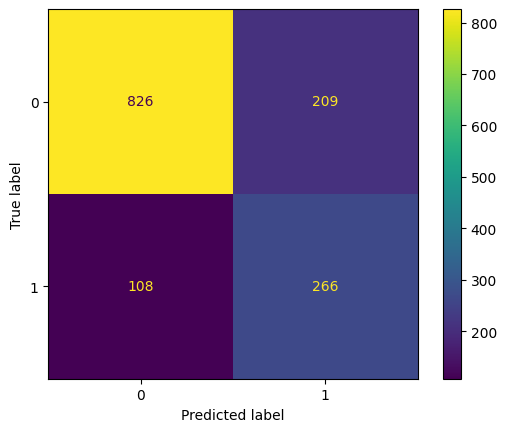

In [37]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_adj_threshold_f1)).plot();

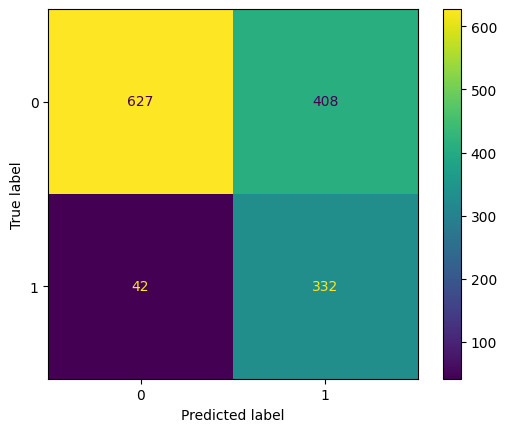

In [38]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_adj_threshold_fbeta)).plot();

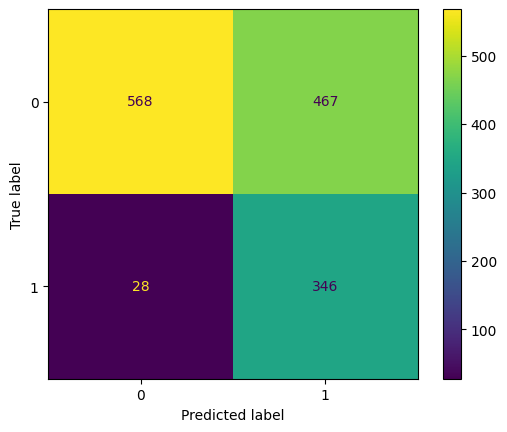

In [39]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_adj_threshold_fbeta1_8)).plot();

In [40]:
best_model = eclf1
dump(best_model, '../../models/best_model_telco_churn_voting_hard.joblib')
best_model = eclf2
dump(best_model, '../../models/best_model_telco_churn_voting_soft.joblib')

['../../models/best_model_telco_churn_voting_soft.joblib']